In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from gensim.models import Word2Vec

## Network Embeddings

In [2]:
model = Word2Vec.load('./graph/n2v/node2vecV2.model')
vectors = model.wv.vectors
indices = model.wv.key_to_index

In [3]:
embeddings_df = pd.DataFrame(data=vectors)
embeddings_df['labels'] = indices

In [4]:
distinct_indices = set(i.split('/')[0] for i in indices)

In [5]:
training = pd.read_csv('audience.csv', low_memory=False).set_index('Username')
inference = pd.read_csv('Apres-profiles-SocialTalk.csv', low_memory=False).set_index('Username')

In [6]:
# inference.loc['nunomarkl'].iloc[:31]

In [7]:
# training.loc['_laqueseaveciina'].iloc[:31]

In [8]:
# when you call someone a data scientist, but they're actually a business analyst
results_dict = {}
for user in inference.index:
    results = model.wv.most_similar(positive=[f'entity/{user}'], topn=10000)

    top_results = [dict(user=node, score=score) for node, score in results if node.startswith('entity')][:25]
    results_dict[user] = top_results

In [9]:
results_dict

{'nunomarkl': [{'user': 'entity/_laqueseaveciina',
   'score': 0.9047414064407349},
  {'user': 'entity/_.dricaa._', 'score': 0.90455561876297},
  {'user': 'entity/_milenebarradas', 'score': 0.8920543789863586},
  {'user': 'entity/_jonas_barros', 'score': 0.8873043656349182},
  {'user': 'entity/_fabio_mnc', 'score': 0.8865187168121338},
  {'user': 'entity/_rafael_dias_21', 'score': 0.8770941495895386},
  {'user': 'entity/_.bebiana._', 'score': 0.8768317699432373},
  {'user': 'entity/_x_meg_x_', 'score': 0.8742882609367371},
  {'user': 'entity/_pilloledivita_', 'score': 0.871652364730835},
  {'user': 'entity/_sfrg_10', 'score': 0.8710579872131348},
  {'user': 'entity/_nabs85lb', 'score': 0.8708319067955017},
  {'user': 'entity/_lynn_saraiva_', 'score': 0.8688119649887085},
  {'user': 'entity/a_leticia_andrade', 'score': 0.8684982657432556},
  {'user': 'entity/_flour_water_salt', 'score': 0.8683424592018127},
  {'user': 'entity/_anarita3_', 'score': 0.8662065863609314},
  {'user': 'entity

## Visualization

In [10]:
scatterplot_df = embeddings_df[embeddings_df['labels'].apply(lambda x: x.startswith('entity/'))]
scatterplot_df = scatterplot_df.sample(min(scatterplot_df.shape[0], 5000))

In [11]:
scatterplot_df.shape

(2622, 33)

In [12]:
from sklearn.cluster import KMeans, SpectralClustering

# clustering = KMeans(
#     n_clusters=15, 
#     random_state=0)

clustering = SpectralClustering(
    n_clusters=10, 
    n_neighbors=25,
    affinity='nearest_neighbors',
    assign_labels='kmeans', 
    n_jobs=7,
    random_state=0)

clustering.fit(scatterplot_df.set_index('labels').values)
results = list(zip(scatterplot_df.set_index('labels').index, clustering.labels_))


In [13]:
pca = PCA(n_components=25)
transformed_df = pca.fit_transform(scatterplot_df.set_index('labels'))

tsne = TSNE(n_components=2)
# tsne = Isomap(n_components=2)
transformed_df = tsne.fit_transform(transformed_df)

/Users/blake/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/blake/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [14]:
cluster_df = pd.DataFrame(data=transformed_df, columns=['X', 'Y'])
cluster_df['cluster'] = clustering.labels_
cluster_df['label'] = scatterplot_df['labels'].values
# cluster_df.to_csv('./app/new_data/full_dataset_clusters.csv')

In [21]:
cluster_df[['label', 'cluster']].to_csv('recommendation_clusters.csv', index=None)

In [15]:
pd.Series(clustering.labels_).value_counts()

1    619
0    467
4    449
2    443
5    198
7    134
6    111
3     87
8     73
9     41
dtype: int64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


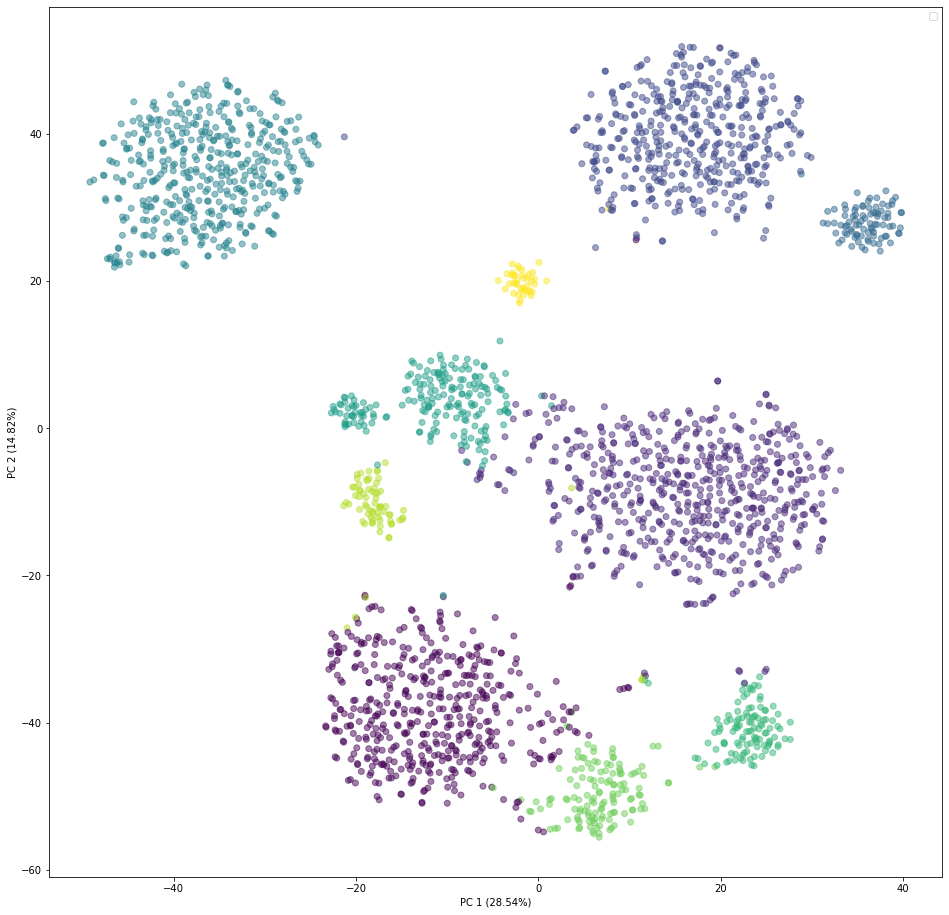

In [16]:
# Create the scatter plot
plt.figure(figsize=(16,16))

sc = plt.scatter(transformed_df[:,0], transformed_df[:,1], cmap='viridis', c=clustering.labels_, alpha=0.5)

# # Add the labels
# list_of_labels = scatterplot_df['labels'].values.tolist()
# for index, label in enumerate(list_of_labels):

#     if not index % 1 == 0:
#         continue

#     # Get the index of the name
#     i = list_of_labels.index(label)

#     # Add the text label
#     labelpad = 0.01   # Adjust this based on your dataset
#     plt.text(transformed_df[i, 0]+labelpad, transformed_df[i, 1]+labelpad, label, fontsize=9)

#     # Mark the labeled observations with a star marker
#     plt.scatter(transformed_df[i,0], transformed_df[i,1], marker='.', s=100)

# Add the axis labels
plt.xlabel('PC 1 (%.2f%%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('PC 2 (%.2f%%)' % (pca.explained_variance_ratio_[1]*100)) 

# Done
plt.legend()
plt.show()